In [143]:
import numpy as np
import matplotlib.pyplot as plt
import databehandling.matlib as matlib
import matplotlib

In [144]:
# Parameters

m = {'name': 'UDGRP', 'units': 'MPa-mm-Mg', 'rho': 2e-09, 
     'E1': 38000, 'E2': 8500, 'v12': 0.28, 'G12': 3400, 
     'XT': 1150, 'YT': 40, "ZT":0, "ZC":0, 'XC': 700, 'YC': 120, 'S12': 60, 'S23': 40, "S13":0, 'f12': -0.5}

d1 = 0.9 # Degradation factor transverse mod and shear mod
d2 = 0.1 # Degradation factor compression
m2 = {'name': 'UDGRP', 'units': 'MPa-mm-Mg', 'rho': 2e-09, 
     'E1': 38000, 'E2': 8500*(1-d1), 'v12': 0.28, 'G12': 3400*(1-d1), 
     'XT': 1150, 'YT': 40, "ZT":0, "ZC":0, 'XC': 700*(1-d2), 'YC': 120, 'S12': 60, 'S23': 40, "S13":0, 'f12': -0.5}

legendsize = 15
def set_plot_props():
    legendsize = 15
    plt.figure(figsize=(9,9))
    #matplotlib.rc('xtick', labelsize=15) 
    #matplotlib.rc('ytick', labelsize=15)
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [145]:
# Functions

def S2D(m):
    return np.array([[        1/m['E1'], -m['v12']/m['E1'],          0],
                     [-m['v12']/m['E1'],         1/m['E2'],          0],
                     [                0,                 0, 1/m['G12']]], float)

def Q2D(m):
    S=S2D(m)
    return np.linalg.inv(S)


def T2Ds(a):
    c,s = np.cos(np.radians(a)), np.sin(np.radians(a))
    return np.array([[ c*c ,  s*s ,   2*c*s],
                     [ s*s ,  c*c ,  -2*c*s],
                     [-c*s,   c*s , c*c-s*s]], float)

# Strain transform, global to local
def T2De(a):
    c,s = np.cos(np.radians(a)), np.sin(np.radians(a))
    return np.array([[   c*c,   s*s,     c*s ],
                     [   s*s,   c*c,    -c*s ],
                     [-2*c*s, 2*c*s, c*c-s*s ]], float)

def Q2Dtransform(Q,a):
    return np.dot(np.linalg.inv( T2Ds(a) ) , np.dot(Q,T2De(a)) )

def laminateThickness(layup):
    return sum([layer['thi'] for layer in layup])

def fE_max_stress(s, m):
    return max(s[0]/m["XT"], -s[0]/m["XC"])
    


def computeA(layup):
    A=np.zeros((3,3),float)
    hbot = -laminateThickness(layup)/2        # bottom of first layer
    for layer in layup:
        m = layer['mat']
        Q = Q2D(m)
        a = layer['ori']
        Qt = Q2Dtransform(Q,a)
        htop = hbot + layer['thi']   # top of current layer
        A = A + Qt*(htop-hbot)
        hbot=htop                    # for the next layer
    return A

def fE_hashin(s,m):
    s1,s2,s3,s23,s13,s12=s[0],s[1],s[2],s[3],s[4],s[5]
    XT,YT,ZT,XC,YC,ZC,S12,S13,S23 = m['XT'], m['YT'], m['ZT'], m['XC'], m['YC'], m['ZC'], m['S12'], m['S13'], m['S23']
    if s1>0:
        R = ( 1/( (s1/XT)**2 + (1/S12**2)*(s12**2 + s13**2) ) )**0.5
        fE_FF=1/R
    if s1<=0:
        fE_FF=-s1/XC
    if (s2+s3)>=0:
        temp=( (1/YT**2)*(s2+s3)**2+(1/S23**2)*(s23**2-s2*s3)+(1/S12**2)*(s12**2+s13**2) )
        if temp==0:
            fE_IFF = 0
        else:
            R = (1/temp)**0.5
            fE_IFF = 1/R
    if (s2+s3)<0:
        b = (1/YC)*((YC/(2*S23))**2-1)*(s2+s3)
        a = (1/(4*S23**2))*(s2+s3)**2+(1/S23**2)*(s23**2-s2*s3)+(1/S12**2)*(s12**2+s13**2)
        if a==0:
            fE_IFF = 0.0
        else:
            c=-1
            R=(-b+(b**2-4*a*c)**0.5)/(2*a)
            fE_IFF = 1/R
    return fE_FF, fE_IFF

def fE_hashin_2D(s, m):
    sV = s
    YT = m["YT"]
    S12 = m["S12"]
    YC = m["YC"]
    S23 = m["S23"]
    if(sV[1] >= 0):
        temp = ((1/YT**2)*sV[1]**2)+((1/S12**2)*sV[2]**2)
        if temp == 0:
            fe = 0
        else:
            R = (1/temp)**0.5
            fe = 1/R
    if(sV[1] < 0):
        #solving with abc-formula
        a = (sV[1]**2/(4*S23**2))+(sV[2]**2/S12**2)
        b = (1/YC)*(((YC**2/(4*S23**2))-1)*sV[1])
        c = -1
        if a == 0: #avoid dividing by zero
            fe = 0
        else:
            R = (-b+(b**2-4*a*c)**0.5)/(2*a)
            fe = 1/R
    return 0, fe


def solve_old(layup, R, P, Fx, T):
    t = laminateThickness(layup)
    Nx=P*R/2 + Fx/(2*np.pi*R)
    Ny=P*R
    Ip = 2*np.pi*R**3*t
    Nxy = T*R*t/Ip

    loads=[Nx,Ny,Nxy]
    A = computeA(layup)
    strains_global=np.linalg.solve(A,loads)
    
    fE_ff = 0
    fE_iff = 0
    fE_iff_2D = 0
    stresses = []
    local_strains = []
    Qs = []
    global_strains = []
    global_stresses = []
    results = {}
    
    for layer in layup:
        angle = layer["ori"]
        strain_local = np.matmul(T2De(angle), strains_global)
        mat = layer["mat"]
        Q = Q2D(mat)
        Q_global = Q2Dtransform(Q, angle)
        
        s = np.matmul(Q, strain_local)
        s_whole = [s[0], s[1], 0, 0, 0, s[2]]
        s_global = np.matmul(Q_global, strains_global)
        
        fE_ff = max(fE_ff, fE_max_stress(s, mat))
        fE_iff_2D = max(fE_iff, fE_hashin_2D(s, mat)[1])
        fE_iff = max(fE_iff, fE_hashin(s_whole, mat)[1])

        stresses.append(s)
        local_strains.append(strain_local)
        Qs.append(Q)
        global_strains.append(strains_global)
        global_stresses.append(s_global)
        
        
    results["stresses"] = stresses
    results["fE_ff"] = fE_ff
    results["strains_local"] = local_strains
    results["fE_iff"] = fE_iff
    results["fE_iff_2D"] = fE_iff
    
    results["A"] = A
    results["Q"] = Qs
    results["global_strains"] = global_strains
    results["global_stresses"] =  global_stresses
    results["loads"] = loads
    return results


def solve(layup, R, P, Fx, T):
    t = laminateThickness(layup)
    Nx=P*R/2 + Fx/(2*np.pi*R)
    Ny=P*R
    Ip = 2*np.pi*R**3*t
    Nxy = T*R*t/Ip

    loads=[Nx,Ny,Nxy]
    A = computeA(layup)
    strains_global=np.linalg.solve(A,loads)
    
    fE_ff = 0
    fE_iff_2D = 0
    stresses = []
    local_strains = []
    Qs = []
    global_strains = []
    global_stresses = []
    results = {}
    
    for layer in layup:
        angle = layer["ori"]
        strain_local = np.matmul(T2De(angle), strains_global)
        mat = layer["mat"]
        Q = Q2D(mat)
        s = np.matmul(Q, strain_local)        
        fE_ff = max(fE_ff, fE_max_stress(s, mat))
        fE_iff = max(fE_iff, fE_hashin_2D(s, mat)[1])
        
    results["fE_ff"] = fE_ff
    results["fE_iff"] = fE_iff
    return results
    
    
def loadcase(x):
    p = 0
    Fx = 0
    T = 0
    if x == 1:
        p = 8
    elif x == 2:
        Fx = 100E3
    elif x == 3:
        T = 2E7
    elif x == 4:
        p = 8
        Fx = 100E3
    elif x == 5:
        Fx = 100E3
        T = 2E7
    return p, Fx, T
            
        

In [146]:
# Case 1 layup A
P,Fx,T = 8,0, 0
R = 75
casenr = 1
layupnr = "A"

t1 = 4.8
fE_ff = []
fE_iff = []
#thetas = list(range(10, 88))
thetas = np.linspace(10,88,500)
set_plot_props()
optimal_theta = 0
min_fE_iff = 100
ff_at_min_iff = 10


for theta1 in thetas:
    layup_iff = [{'mat':m,  'ori':  theta1,  'thi':t1/2},
              {'mat':m,  'ori': -theta1,  'thi':t1/2}]
    layup_ff = [{'mat':m2,  'ori':  theta1,  'thi':t1/2},
              {'mat':m2,  'ori': -theta1,  'thi':t1/2}]
    
    res_ff = solve(layup_ff,R=75,P=P*3,Fx=Fx*3,T=T*3)
    res_iff = solve(layup_iff,R=75,P=P*1.2,Fx=Fx*1.2,T=T*1.2)
    
    fE_iff_new = res_iff["fE_iff"]
    fE_ff_new = res_ff["fE_ff"]
    
    if fE_iff_new < min_fE_iff:
        min_fE_iff = fE_iff_new
        optimal_theta = theta1
        ff_at_min_iff = fE_ff_new
        #print(fE_iff_new)
        
    fE_ff.append(res_ff["fE_ff"])
    fE_iff.append(res_iff["fE_iff"])
    
    #print(fE_ff)
print("Lowest ff", min(fE_ff))
print("Lowest iff", min(fE_iff))
print("ff at min iff", ff_at_min_iff)
print("optimal theta1", optimal_theta)

plt.plot(thetas, fE_iff, label="iff hashin")
plt.plot(thetas, fE_ff, label="ff max stress")
plt.xlabel("$\\theta$")
plt.ylabel("$f_E$")
plt.title(f"Case {casenr}: [{P=}, {Fx=}, {T=}], layup {layupnr}, tot. thickness {t1} mm")
plt.legend(prop={'size': legendsize})
plt.savefig(f'output/Case{casenr} - layup{layupnr}.png')

UnboundLocalError: local variable 'fE_iff' referenced before assignment

<Figure size 648x648 with 0 Axes>

In [147]:
# Case 2 layup A
P,Fx,T = 0,100E3, 0
R = 75
casenr = 2
layupnr = "A"

t1 = 0.2
fE_ff, fE_iff, fE_iff_2D = [], [], []

#thetas = list(range(10, 30))
thetas = np.linspace(10,88, 100)
set_plot_props()
ff_at_min_iff = 10
min_fE_iff = 10
optimal_theta = -1

for theta1 in thetas:
    layup_iff = [{'mat':m,  'ori':  theta1,  'thi':t1/2},
              {'mat':m,  'ori': -theta1,  'thi':t1/2}]
    layup_ff = [{'mat':m2,  'ori':  theta1,  'thi':t1/2},
              {'mat':m2,  'ori': -theta1,  'thi':t1/2}]
    
    res_ff = solve(layup_ff,R=75,P=P*3,Fx=Fx*3,T=T*3)
    res_iff = solve(layup_iff,R=75,P=P*1.2,Fx=Fx*1.2,T=T*1.2)
    
    fE_ff_new = res_ff["fE_ff"]
    fE_iff_new = res_iff["fE_iff"]
    
    if fE_iff_new < min_fE_iff:
        min_fE_iff = fE_iff_new
        optimal_theta = theta1
        ff_at_min_iff = fE_ff_new    
    
    fE_ff.append(res_ff["fE_ff"])
    fE_iff.append(res_iff["fE_iff"])

print("Lowest ff", min(fE_ff))
print("Lowest iff", min(fE_iff))
print("optimal theta1", optimal_theta1)
print("ff at min iff", ff_at_min_iff)
plt.plot(thetas, fE_iff, label="iff hashin")
plt.plot(thetas, fE_ff, label="ff max stress")
plt.xlabel("$\\theta$")
plt.ylabel("$f_E$")
plt.title(f"Case {casenr}: [{P=}, {Fx=}, {T=}], layup {layupnr}, tot. thickness {t1} mm")
plt.legend(prop={'size': legendsize})
plt.savefig(f'output/Case{casenr} - layup{layupnr}.png')

UnboundLocalError: local variable 'fE_iff' referenced before assignment

<Figure size 648x648 with 0 Axes>

In [150]:
# Case 3 layup A
P,Fx,T = 0, 0, 20E6
R = 75
casenr = 3
layupnr = "A"

t1 = 5.0
fE_ff = []
fE_iff = []
thetas = list(range(10, 89))
set_plot_props()
ff_at_min_iff = 100
min_fE_iff = 100

for theta1 in thetas:
    layup_iff = [{'mat':m,  'ori':  theta1,  'thi':t1/2},
              {'mat':m,  'ori': -theta1,  'thi':t1/2}]
    layup_ff = [{'mat':m2,  'ori':  theta1,  'thi':t1/2},
              {'mat':m2,  'ori': -theta1,  'thi':t1/2}]
    
    res_ff = solve(layup_ff,R=75,P=P*3,Fx=Fx*3,T=T*3)
    res_iff = solve(layup_iff,R=75,P=P*1.2,Fx=Fx*1.2,T=T*1.2)
    
    fE_ff_new = res_ff["fE_ff"]
    fE_iff_new = res_iff["fE_iff"]
    
    if fE_iff_new < min_fE_iff:
        min_fE_iff = fE_iff_new
        optimal_theta = theta1
        ff_at_min_iff = fE_ff_new

    
    fE_ff.append(res_ff["fE_ff"])
    fE_iff.append(res_iff["fE_iff"])
    #print(fE_ff)
    


print("Lowest ff", min(fE_ff))
print("Lowest iff", min(fE_iff))
optimal_theta1 = 45
print("optimal theta1", optimal_theta1)
print("ff at min iff", ff_at_min_iff)
plt.plot(thetas, fE_iff, label="iff hashin")
plt.plot(thetas, fE_ff, label="ff max stress")
plt.xlabel("$\\theta$")
plt.ylabel("$f_E$")
plt.title(f"Case {casenr}: [{P=}, {Fx=}, {T=}], layup {layupnr}, tot. thickness {t1} mm")
plt.legend(prop={'size': legendsize})
plt.savefig(f'output/Case{casenr} - layup{layupnr}.png')


UnboundLocalError: local variable 'fE_iff' referenced before assignment

<Figure size 648x648 with 0 Axes>

In [149]:
# Case 4 layup A
P,Fx,T = 8, 100E3, 0
R = 75
casenr = 4
layupnr = "A"

t1 = 7.1
fE_ff = []
fE_iff = []
thetas = list(range(11, 88))
set_plot_props()
ff_at_min_iff = 100
min_fE_iff = 100
optimal_theta = -1

for theta1 in thetas:
    layup_iff = [{'mat':m,  'ori':  theta1,  'thi':t1/2},
              {'mat':m,  'ori': -theta1,  'thi':t1/2}]
    layup_ff = [{'mat':m2,  'ori':  theta1,  'thi':t1/2},
              {'mat':m2,  'ori': -theta1,  'thi':t1/2}]
    
    res_ff = solve(layup_ff,R=75,P=P*3,Fx=Fx*3,T=T*3)
    res_iff = solve(layup_iff,R=75,P=P*1.2,Fx=Fx*1.2,T=T*1.2)
    
    fE_ff_new = res_ff["fE_ff"]
    fE_iff_new = res_iff["fE_iff"]
    
    if fE_iff_new < min_fE_iff:
        min_fE_iff = fE_iff_new
        optimal_theta = theta1
        ff_at_min_iff = fE_ff_new
    fE_ff.append(res_ff["fE_ff"])
    fE_iff.append(res_iff["fE_iff"])
    #print(fE_ff)

print("Lowest ff", min(fE_ff))
print("Lowest iff", min(fE_iff))
print("ff at min iff", ff_at_min_iff)

print("optimal theta1", optimal_theta1)
plt.plot(thetas, fE_iff, label="iff hashin")
plt.plot(thetas, fE_ff, label="ff max stress")
plt.xlabel("$\\theta$")
plt.ylabel("$f_E$")
plt.title(f"Case {casenr}: [{P=}, {Fx=}, {T=}], layup {layupnr}, tot. thickness {t1} mm")
plt.legend(prop={'size': legendsize})
plt.savefig(f'output/Case{casenr} - layup{layupnr}.png')

UnboundLocalError: local variable 'fE_iff' referenced before assignment

<Figure size 648x648 with 0 Axes>

Lowest ff 0.7413430125786993
Lowest iff 0.9978867259544054
ff at min iff 0.7821179308339442
optimal theta1 34


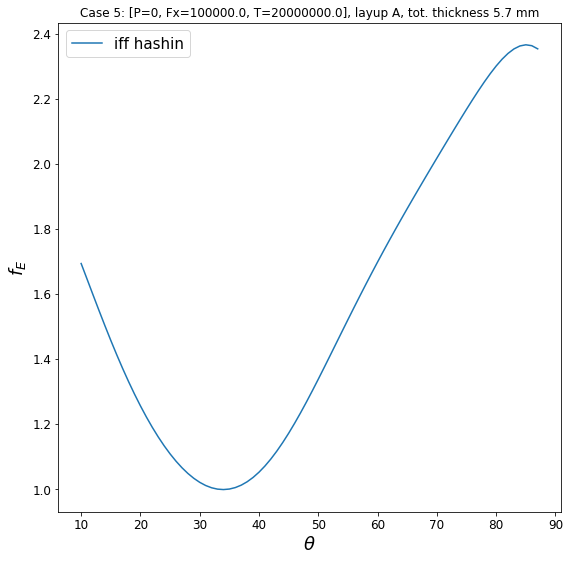

In [136]:
# Case 5 layup A
P,Fx,T = 0, 100E3, 20E6
R = 75
casenr = 5
layupnr = "A"

t1 = 5.7
fE_ff = []
fE_iff = []
thetas = list(range(10, 88))
set_plot_props()
optimal_theta = -1
ff_at_min_iff = 100
min_fE_iff = 100

for theta1 in thetas:
    layup_iff = [{'mat':m,  'ori':  theta1,  'thi':t1/2},
              {'mat':m,  'ori': -theta1,  'thi':t1/2}]
    
    layup_ff = [{'mat':m2,  'ori':  theta1,  'thi':t1/2},
              {'mat':m2,  'ori': -theta1,  'thi':t1/2}]
    
    
    
    res_ff = solve(layup_ff,R=75,P=P*3,Fx=Fx*3,T=T*3)
    res_iff = solve(layup_iff,R=75,P=P*1.2,Fx=Fx*1.2,T=T*1.2)
    
    fE_ff_new = res_ff["fE_ff"]
    fE_iff_new = res_iff["fE_iff"]
    
    if fE_iff_new < min_fE_iff:
        min_fE_iff = fE_iff_new
        optimal_theta = theta1
        ff_at_min_iff = fE_ff_new
    
    fE_ff.append(res_ff["fE_ff"])
    fE_iff.append(res_iff["fE_iff"])
    #print(fE_ff)

print("Lowest ff", min(fE_ff))
print("Lowest iff", min(fE_iff))
print("ff at min iff", ff_at_min_iff)

print("optimal theta1", optimal_theta)
plt.plot(thetas, fE_iff, label="iff hashin")
#plt.plot(thetas, fE_ff, label="ff max stress")


plt.xlabel("$\\theta$")
plt.ylabel("$f_E$")
plt.title(f"Case {casenr}: [{P=}, {Fx=}, {T=}], layup {layupnr}, tot. thickness {t1} mm")
plt.legend(prop={'size': legendsize})
plt.savefig(f'output/Case{casenr} - layup{layupnr}.png')

In [ ]:
# Case 2 layup B
P,Fx,T = 8,0, 0
R = 75
casenr = 2
layupnr = "B"

t = 1

theta_iff = 11
theta_ff = 88

thetas = list(range(11, 88))
set_plot_props()

t1_all = np.linspace(0, 1, 100)
fE_ff = np.zeros_like(t1_all)
fE_iff = np.zeros_like(t1_all)

for  i, t1 in enumerate(t1_all):
    t2 = t-t1
    layup_iff = [{'mat':m,  'ori':  theta_iff,  'thi':t1/2},
                 {'mat':m,  'ori': -theta_iff,  'thi':t1/2},
                 {'mat':m,  'ori':  theta_ff,  'thi':t2/2},
                 {'mat':m,  'ori': -theta_ff,  'thi':t2/2}]

    layup_ff = [ {'mat':m2,  'ori':  theta_iff,  'thi':t1/2},
                 {'mat':m2,  'ori': -theta_iff,  'thi':t1/2},
                 {'mat':m2,  'ori':  theta_ff,  'thi':t2/2},
                 {'mat':m2,  'ori': -theta_ff,  'thi':t2/2}]

    res_ff = solve(layup_ff,R=75,P=P*3,Fx=Fx*3,T=T*3)
    
    res_iff = solve(layup_iff,R=75,P=P*1.2,Fx=Fx*1.2,T=T*1.2)
    
    fE_ff[i] = res_ff["fE_ff"]
    fE_iff[i] = res_iff["fE_iff"]
    
print("Lowest ff", min(fE_ff))
print("Lowest iff", min(fE_iff))
optimal_theta1 = 53
print("optimal theta1", optimal_theta1)

#plt.plot(thetas, fE_iff, label="iff hashin")
plt.plot(t1_all, fE_ff, label="ff")
plt.plot(t1_all, fE_iff, label="ff")
plt.xlabel("t1")
plt.ylabel("$f_E$")
plt.title(f"Case {casenr}: [{P=}, {Fx=}, {T=}], layup {layupnr}, tot. thickness {t1} mm")
plt.legend(prop={'size': legendsize})
plt.savefig(f'output/Case{casenr} - layup{layupnr}.png')

In [ ]:
# Case 2 layup B
P,Fx,T = 8,0, 0
R = 75
casenr = 2
layupnr = "B"

t = 1

theta_iff = 11
theta_ff = 88

thetas = list(range(11, 88))
set_plot_props()

t1_all = np.linspace(0, 1, 100)
fE_ff = np.zeros_like(t1_all)
fE_iff = np.zeros_like(t1_all)


t1=0.2
t2 = 0.2
layup_iff = [{'mat':m,  'ori':  theta_iff,  'thi':t1/2},
             {'mat':m,  'ori': -theta_iff,  'thi':t1/2},
             {'mat':m,  'ori':  theta_ff,  'thi':0},
             {'mat':m,  'ori': -theta_ff,  'thi':0}]

layup_ff = [ {'mat':m2,  'ori':  theta_iff,  'thi':t1/2},
             {'mat':m2,  'ori': -theta_iff,  'thi':t1/2},
             {'mat':m2,  'ori':  theta_ff,  'thi':t2/2},
             {'mat':m2,  'ori': -theta_ff,  'thi':t2/2}]

res_ff = solve(layup_ff,R=75,P=P*3,Fx=Fx*3,T=T*3)
res_iff = solve(layup_iff,R=75,P=P*1.2,Fx=Fx*1.2,T=T*1.2)

fE_ff = res_ff["fE_ff"]
fE_iff = res_iff["fE_iff"]
    
#print("Lowest ff", min(fE_ff))
print("Lowest iff", fE_iff)
optimal_theta1 = 53
print("optimal theta1", optimal_theta1)

#plt.plot(thetas, fE_iff, label="iff hashin")
#plt.plot(t1_all, fE_ff, label="ff")
3#plt.plot(t1_all, fE_iff, label="ff")
#plt.xlabel("t1")
#plt.ylabel("$f_E$")
#plt.title(f"Case {casenr}: [{P=}, {Fx=}, {T=}], layup {layupnr}, tot. thickness {t1} mm")
#plt.legend(prop={'size': legendsize})
#plt.savefig(f'output/Case{casenr} - layup{layupnr}.png')


In [ ]:
# Case 2 last attempt
# Case 2 layup B
P,Fx,T = 0,100E3, 0
R = 75
casenr = 2
layupnr = "B"

t1 = 0.2
t2 = 0.1
set_plot_props()

theta1=11
#theta2=88

layup_iff = [{'mat':m,  'ori':  11,  'thi':t1/2},
          {'mat':m,  'ori': -11,  'thi':t1/2}]

#t1=0.2
#t2 = 0.2
#layup_iff = [{'mat':m,  'ori':  11,  'thi':t1/2},
#             {'mat':m,  'ori': -11,  'thi':t1/2},
#             {'mat':m,  'ori':  88,  'thi':0},
#             {'mat':m,  'ori': -88,  'thi':0}]

layup_ff = [{'mat':m2,  'ori':  theta1,  'thi':t1/2},
          {'mat':m2,  'ori': -theta1,  'thi':t1/2}]

res_ff = solve(layup_ff,R=75,P=P*3,Fx=Fx*3,T=T*3)
res_iff = solve(layup_iff,R=75,P=P*1.2,Fx=Fx*1.2,T=T*1.2)

fE_ff = res_ff["fE_ff"]
fE_iff = res_iff["fE_iff"]

#print(fE_iff)


#print(fE_ff)
#print("Lowest ff", fE_ff)
#print("Lowest iff", fE_iff)
#print("optimal theta1", optimal_theta1)

#plt.plot(thetas, fE_iff, label="iff hashin")
#plt.plot(thetas, fE_ff, label="ff")
#plt.xlabel("$\\theta$")
#plt.ylabel("$f_E$")
#plt.title(f"Case {casenr}: [{P=}, {Fx=}, {T=}], layup {layupnr}, tot. thickness {t1} mm")
#plt.legend(prop={'size': legendsize})
#plt.savefig(f'output/Case{casenr} - layup{layupnr}.png')

In [132]:
# Case 2 layup A
P,Fx,T = 0,100E3, 0
R = 75
casenr = 2
layupnr = "A"

t1 = 0.2
t2 = 0.2

thetas = list(range(11, 88))
set_plot_props()

theta_iff = 11
theta_ff = 88

layup_iff = [{'mat':m,  'ori':  theta_iff,  'thi':t1/2},
          {'mat':m,  'ori': -theta_iff,  'thi':t1/2}]

layup_iff = [{'mat':m,  'ori':  theta_iff,  'thi':t1/2},
             {'mat':m,  'ori': -theta_iff,  'thi':t1/2},
             {'mat':m,  'ori': 88,  'thi':0.5}]

layup_ff = [{'mat':m,  'ori':  88,  'thi':t1/2},
             {'mat':m,  'ori': -88,  'thi':t1/2},
             {'mat':m,  'ori': 88,  'thi':0}]



#layup_ff = [{'mat':m2,  'ori':  theta1,  'thi':t1/2},
#          {'mat':m2,  'ori': -theta1,  'thi':t1/2}]

res_ff = solve(layup_ff,R=75,P=P*3,Fx=Fx*3,T=T*3)
res_iff = solve(layup_iff,R=75,P=P*1.2,Fx=Fx*1.2,T=T*1.2)


fE_ff.append(res_ff["fE_ff"])
fE_iff.append(res_iff["fE_iff"])

#print(fE_ff)
print("Lowest ff", min(fE_ff))
print("Lowest iff", min(fE_iff))
optimal_theta1 = 11
print("optimal theta1", optimal_theta1)

#plt.plot(thetas, fE_iff, label="iff hashin")
#plt.plot(thetas, fE_ff, label="ff")
#plt.xlabel("$\\theta$")
#plt.ylabel("$f_E$")
#plt.title(f"Case {casenr}: [{P=}, {Fx=}, {T=}], layup {layupnr}, tot. thickness {t1} mm")
#plt.legend(prop={'size': legendsize})
#plt.savefig(f'output/Case{casenr} - layup{layupnr}.png')

Lowest ff 0.0023671170996902016
Lowest iff 1.6932102994086895
optimal theta1 11


<Figure size 648x648 with 0 Axes>

In [ ]:
# Case 1 LAYUP b - special case
P,Fx,T = loadcase(1)
R = 75
casenr = 1
layupnr = "B"


theta1 = 30
theta2 = 80

x_er = []
y_er = []
for theta2 in [50,60,70,80]:
    set_plot_props()

    forhold = np.linspace(1.01,5, 1000)
    fE_iff_er = []
    min_forhold = 0
    min_fE = 100

    t = 1
    for f in forhold:

        t1 = t - t/f
        t2 = t/f
        #print(t1 + t2)

        layup     = [{'mat':m,  'ori':  theta1,  'thi':t1/2},
                     {'mat':m,  'ori': -theta1,  'thi':t1/2},
                     {'mat':m,  'ori':  theta2,  'thi':t2/2},
                     {'mat':m,  'ori': -theta2,  'thi':t2/2}]

        layup2     = [{'mat':m2,  'ori':  theta1,  'thi':t1/2},
                     {'mat':m2,  'ori': -theta1,  'thi':t1/2},
                     {'mat':m2,  'ori':  theta2,  'thi':t2/2},
                     {'mat':m2,  'ori': -theta2,  'thi':t2/2}]

        res = solve(layup,R, P=P*1.2, Fx=Fx*1.2, T=T*1.2)
        res_ff = solve(layup,R, P=P*3, Fx=Fx*3, T=T*3)

        fE = res["fE_iff"]
        #fE_ff = res_ff["fE_ff"]

        if fE < min_fE:
            min_fE = fE
            min_forhold = t1/t2
            #print(fE)


        fE_iff_er.append(fE)

    y_er.append(fE_iff_er)
    #print(f"{fE_iff=}")
    #plt.plot(forhold, fE_iff_er)
for y,l in zip(y_er, ["30-50", "30-60", "30-70", "30-80"]:
    
    plt.plot(forhold, y, label=l)
    #print(min(fE_iff_er))
    #print("min forhold", min_forhold)
    #print("min forhold", min_pos)
